In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [39]:
data = pd.read_csv("/Users/sethfried/Downloads/2011-2020.csv")
data.head()

ID                NAME  LATITUDE  LONGITUDE  STNELEV  Year  \
0  ACW00011604                SAVE   57.7667    11.8667     18.0  2011   
1  ACW00011604                SAVE   57.7667    11.8667     18.0  2012   
2  ACW00011604                SAVE   57.7667    11.8667     18.0  2013   
3  AE000041196  SHARJAH_INTER_AIRP   25.3330    55.5170     34.0  2011   
4  AE000041196  SHARJAH_INTER_AIRP   25.3330    55.5170     34.0  2012   

   January  February   March   April     May    June    July  August  \
0    -83.0    -132.0   278.0  1040.0  1213.0  1663.0  1875.0  1723.0   
1    121.0     -98.0   592.0   646.0  1365.0  1426.0  1771.0  1748.0   
2   -104.0     -93.0   -48.0   595.0     NaN  1612.0  1855.0  1802.0   
3   1950.0    2060.0  2280.0  2760.0  3240.0  3447.0  3580.0  3650.0   
4   1837.0    1987.0     NaN     NaN     NaN     NaN     NaN     NaN   

   September  October  November  December  
0     1466.0    987.0     721.0     428.0  
1     1362.0    826.0     620.0    -234.0  
2     1359.0   1042.0     601.0       NaN  
3     3316.0   2940.0    2390.0    1905.0  
4        NaN      NaN       NaN       NaN

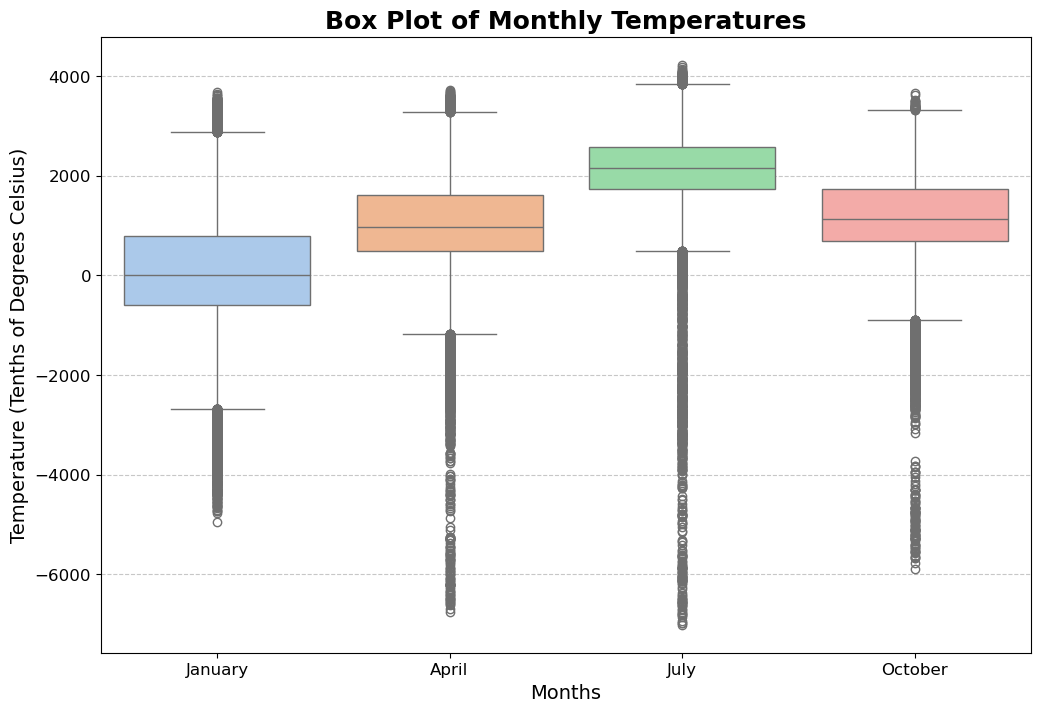

In [40]:
#box plot for monthly temperatures
plt.figure(figsize=(12, 8))
selected_months = ['January', 'April','July','October']
sns.boxplot(data=data[selected_months], palette="pastel")

plt.title("Box Plot of Monthly Temperatures", fontsize=18, weight='bold')
plt.ylabel("Temperature (Tenths of Degrees Celsius)", fontsize=14)
plt.xlabel("Months", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



/var/folders/5b/zyfxmg1n27sc10rqxm40tr3r0000gn/T/ipykernel_29740/2728726041.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/5b/zyfxmg1n27sc10rqxm40tr3r0000gn/T/ipykernel_29740/2728726041.py:25: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



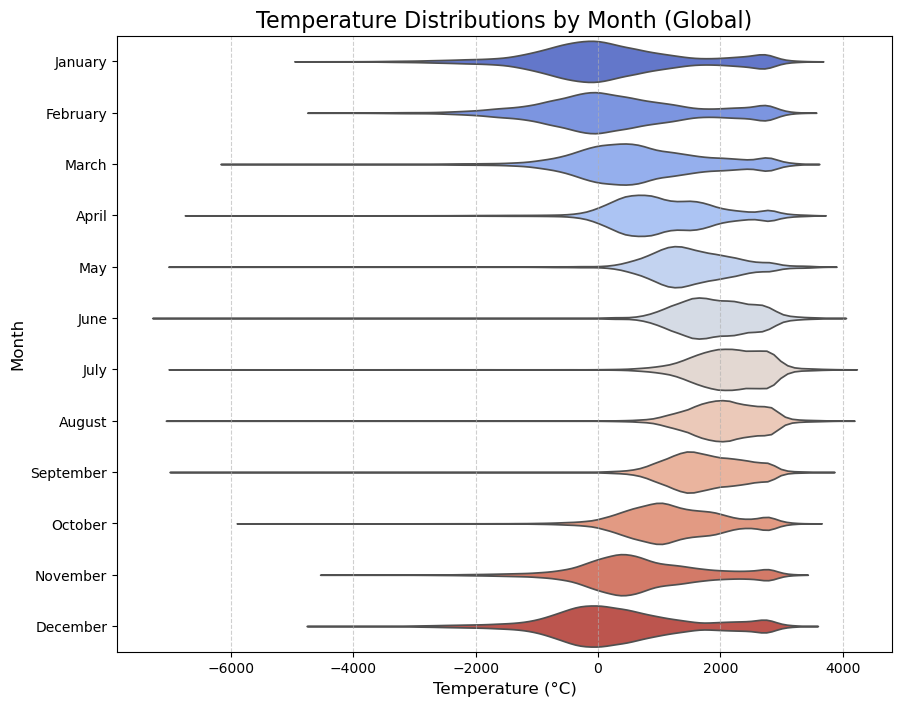

In [41]:
# Prepare data for ridgeline plot (use monthly temperature columns)
monthly_temp_columns = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Reshape the data to long format for easier plotting
long_format = data.melt(
    id_vars=["Year", "ID", "NAME"], 
    value_vars=monthly_temp_columns,
    var_name="Month",
    value_name="Temperature"
)

# Remove missing values
long_format = long_format.dropna(subset=["Temperature"])

# Sort months by order
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
long_format["Month"] = pd.Categorical(long_format["Month"], categories=month_order, ordered=True)

# Create ridgeline plot
plt.figure(figsize=(10, 8))
sns.violinplot(
    x="Temperature", y="Month", data=long_format,
    scale="width", inner=None, palette="coolwarm", cut=0
)
plt.title("Temperature Distributions by Month (Global)", fontsize=16)
plt.xlabel("Temperature (°C)", fontsize=12)
plt.ylabel("Month", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [42]:
# Filter data for the year 2020
data_2020 = data[data['Year'] == 2020]

# Create a scatter plot on the map for January 2020 temperatures
fig = px.scatter_geo(
    data_2020,
    lat="LATITUDE", 
    lon="LONGITUDE", 
    color="January", 
    hover_name='NAME',
    title='2020 January Temperature by Location',
    opacity=0.6
)

fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()


In [43]:
from urllib.request import urlopen
import json

# Load country boundaries GeoJSON
with urlopen('https://cdn.jsdelivr.net/npm/world-atlas@2/countries-110m.json') as response:
    countries = json.load(response)

# Calculate country-level averages for January 2020
data_2020['FIPS'] = data_2020['ID'].str[:2]
average_by_country = data_2020.groupby('FIPS').mean(numeric_only=True).reset_index()

# Add country names using an external mapping file
fips_to_iso = pd.read_csv("https://raw.githubusercontent.com/mysociety/gaze/master/data/fips-10-4-to-iso-country-codes.csv")
average_by_country = pd.merge(average_by_country, fips_to_iso, how='left', left_on='FIPS', right_on='FIPS 10-4')

# Create the choropleth map
fig = px.choropleth(
    average_by_country,
    geojson=countries,
    locations='Name',
    locationmode='country names',
    color='January',
    color_continuous_scale="Viridis",
    title='2020 January Temperature Averages by Country'
)

fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()


/var/folders/5b/zyfxmg1n27sc10rqxm40tr3r0000gn/T/ipykernel_29740/1113674455.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
# Load GeoJSON for country boundaries
def load_geojson():
    with urlopen('https://cdn.jsdelivr.net/npm/world-atlas@2/countries-110m.json') as response:
        return json.load(response)

# Prepare data for choropleth maps
def prepare_data(file_path):
    # Load dataset
    df = pd.read_csv(file_path)

    # Filter for 2020 data
    df_2020 = df[df['Year'] == 2020]

    # Add FIPS codes for country mapping
    df_2020['FIPS'] = df_2020['ID'].str[:2]
    fips_to_iso = pd.read_csv("https://raw.githubusercontent.com/mysociety/gaze/master/data/fips-10-4-to-iso-country-codes.csv")
    average_by_country = df_2020.groupby('FIPS').mean(numeric_only=True).reset_index()
    average_by_country = pd.merge(average_by_country, fips_to_iso, how='left', left_on='FIPS', right_on='FIPS 10-4')

    return average_by_country

# Create individual choropleth map for a given month
def create_choropleth(data, countries_geojson, month):
    fig = px.choropleth(
        data,
        geojson=countries_geojson,
        locations='Name',
        locationmode='country names',
        color=month,
        color_continuous_scale="Viridis",
        title=f'2020 {month} Temperature Averages by Country'
    )
    fig.update_geos(showcoastlines=False, visible=False)
    return fig

# Create subplot with all months
def create_monthly_choropleths(data, countries_geojson):
    months = ["January", "February", "March", "April", "May", "June", 
              "July", "August", "September", "October", "November", "December"]

    # Create a 3x4 subplot layout
    fig = make_subplots(rows=3, cols=4, subplot_titles=months, specs=[[{'type': 'choropleth'}]*4]*3)

    # Add choropleth maps for each month
    for i, month in enumerate(months):
        row, col = divmod(i, 4)
        choropleth_map = create_choropleth(data, countries_geojson, month)
        fig.add_trace(choropleth_map.data[0], row=row+1, col=col+1)

    # Update layout
    fig.update_layout(
        title_text="2020 Monthly Temperature Averages by Country",
        showlegend=False,
        height=800,
        geo=dict(showframe=False, showcoastlines=False),
    )

    return fig


countries_geojson = load_geojson()
data = prepare_data('/Users/sethfried/Downloads/2011-2020.csv')

# Create the monthly choropleths
fig = create_monthly_choropleths(data, countries_geojson)
fig.show()


/var/folders/5b/zyfxmg1n27sc10rqxm40tr3r0000gn/T/ipykernel_29740/2701558475.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

